# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [48]:
# Code Here
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, auc

In [8]:
pip install palmerpenguins

In [3]:
from palmerpenguins import load_penguins

In [26]:
penguins = load_penguins()
df = pd.get_dummies(penguins, columns = ['sex', 'island'])
df['species'] = df['species'].astype("category")
df = df.dropna()

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [43]:
X = df.drop(columns=["species"])
y = df["species"]

ct = ColumnTransformer(
    transformers = [
      ("standardize", StandardScaler(), make_column_selector(dtype_include = np.floating))
    ],
    remainder = "passthrough"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y)

In [44]:
models = {
    "kNN (k = 5)":  Pipeline([("preprocess", ct), ("classifier", KNeighborsClassifier(n_neighbors = 5))]),
    "kNN (k = 15)": Pipeline([("preprocess", ct), ("classifier", KNeighborsClassifier(n_neighbors = 15))]),
    "Decision Tree (depth = 3)": Pipeline([("preprocess", ct), ("classifier", DecisionTreeClassifier(max_depth = 3))]),
    "Decision Tree (depth = 5)": Pipeline([("preprocess", ct), ("classifier", DecisionTreeClassifier(max_depth = 5))]),
}


In [45]:
results = []

for name, model in models.items():
    print(f"{name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(classification_report(y_test, y_pred))

    results.append({"Model": name, "Accuracy": acc})

results_df = pd.DataFrame(results).sort_values("Accuracy", ascending = False)
results_df


kNN (k = 5)
Accuracy: 0.9883720930232558
              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.99        38
   Chinstrap       1.00      0.94      0.97        17
      Gentoo       1.00      1.00      1.00        31

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86

kNN (k = 15)
Accuracy: 0.9883720930232558
              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.99        38
   Chinstrap       1.00      0.94      0.97        17
      Gentoo       1.00      1.00      1.00        31

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86

Decision Tree (depth = 3)
Accuracy: 0.9418604651162791
              precision    recall  f1-score   support

      Adelie       0.88      1.00      0.94  

,Model,Accuracy
0,kNN (k = 5),0.988372
1,kNN (k = 15),0.988372
3,Decision Tree (depth = 5),0.976744
2,Decision Tree (depth = 3),0.941860


In [49]:
# creating ROC plot for Gentoo since it had the highest F1 scores overall
from plotnine import *

model = models["kNN (k = 5)"]

y_proba = model.predict_proba(X_test)

classes = model.classes_
gentoo_idx = np.where(classes == "Gentoo")[0][0]

y_test_bin = (y_test == "Gentoo").astype(int)

fpr, tpr, _ = roc_curve(y_test_bin, y_proba[:, gentoo_idx])
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({
    "False Positive Rate": fpr,
    "True Positive Rate": tpr
})

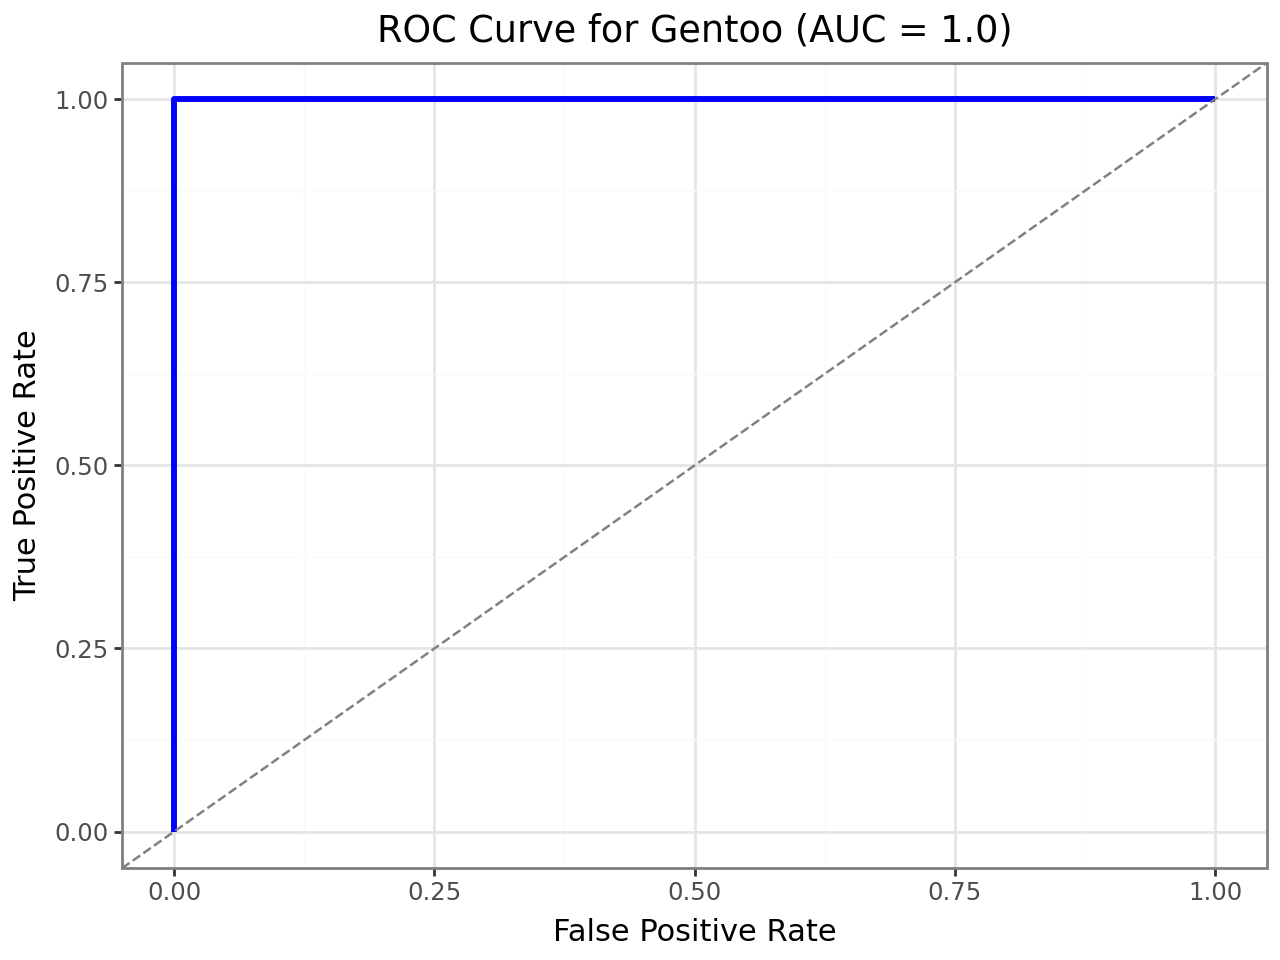

In [51]:
# roc plot
(
    ggplot(roc_df, aes(
        x = "False Positive Rate",
        y = "True Positive Rate"))
    + geom_line(color = "blue", size = 1.2)
    + geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray")
    + labs(
        title = f"ROC Curve for Gentoo (AUC = {roc_auc:})",
        x = "False Positive Rate",
        y = "True Positive Rate"
    )
    + theme_bw()
)